In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Meas = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


# Exploratory Climate Analysis

2016-08-23


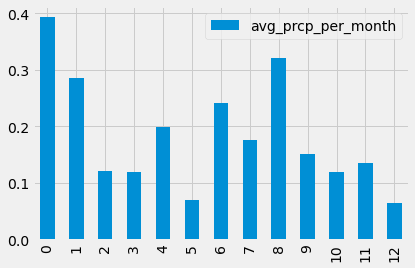

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

session.query(Meas.date).order_by(Meas.date.desc()).first()
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores

sel = [Meas.date,
      func.avg(Meas.prcp)]
prcp_prev = session.query(*sel).\
    filter((Meas.date)>= year_ago).\
    group_by(func.strftime("%Y-%m",Meas.date)).all()
prcp_prev
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(prcp_prev, columns = ['date', 'avg_prcp_per_month'])

# Sort the dataframe by date

df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

df.plot.bar()
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,avg_prcp_per_month
count,13.000000
mean,0.184412
std,0.099626
min,0.063951
25%,0.120234
50%,0.151317
75%,0.241111
max,0.392642


In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [14]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.station)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.execute("SELECT COUNT(s.name), s.station, s.name FROM station AS s LEFT JOIN measurement AS m ON m.station = s.station GROUP BY name ORDER BY COUNT(s.name) DESC").fetchall()

[(2772, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (2724, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2709, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (2669, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (2612, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 (2202, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (1979, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (1372, 'USC00517948', 'PEARL CITY, HI US'),
 (511, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US')]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#lowest temp
low = session.query(Meas.tobs, Station.station, Station.name).\
                filter(Station.station == 'USC00519281').\
                order_by(Meas.tobs.asc()).limit(1).all()
print(f"Low Temp: {low}")

#Highest temp
high = session.query(Meas.tobs, Station.station, Station.name).\
                filter(Station.station == 'USC00519281').\
                order_by(Meas.tobs.desc()).limit(1).all()
print(f"High Temp: {high}")

#Average temp
avg = session.query(func.avg(Meas.tobs), Station.station, Station.name).\
                filter(Station.station == 'USC00519281').all()
print(f"Avg Temp: {avg}")

Low Temp: [(53.0, 'USC00519281', 'WAIHEE 837.5, HI US')]
High Temp: [(87.0, 'USC00519281', 'WAIHEE 837.5, HI US')]
Avg Temp: [(73.09795396419437, 'USC00519281', 'WAIHEE 837.5, HI US')]


Text(0, 0.5, 'Temperature')

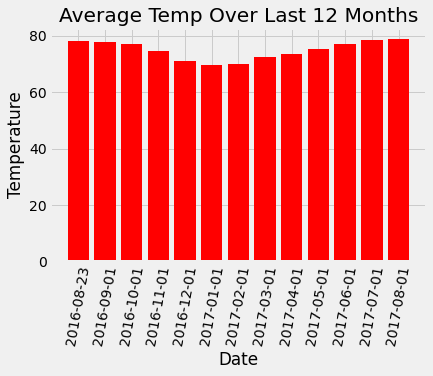

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.execute("SELECT COUNT(m.tobs), s.station, s.name FROM station AS s LEFT JOIN measurement AS m ON m.station = s.station GROUP BY name ORDER BY COUNT(s.name) DESC").fetchall()

sel = [Meas.date,
      func.avg(Meas.tobs)]
tobs_prev = session.query(*sel).\
    filter((Meas.date)>= year_ago).\
    group_by(func.strftime("%Y-%m",Meas.date)).all()
tobs_prev

tobs_df = pd.DataFrame(tobs_prev, columns = ['date', 'tobs'])
tobs_df

x_axis = [value for value in tobs_df['date']]

y_axis = [value for value in round(tobs_df['tobs'],1)]
x_axis
plt.bar(x_axis, y_axis, color = 'red', alpha = 1, align = 'center',)
plt.xticks(rotation=80)
plt.title("Average Temp Over Last 12 Months")
plt.xlabel('Date')
plt.ylabel('Temperature')




In [18]:
from flask import Flask, jsonify

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)).\
        filter(Meas.date >= start_date).filter(Meas.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-02-28','2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


<AxesSubplot:title={'center':'Trip Avg Temp'}, xlabel='Trip Dates', ylabel='Temperature'>

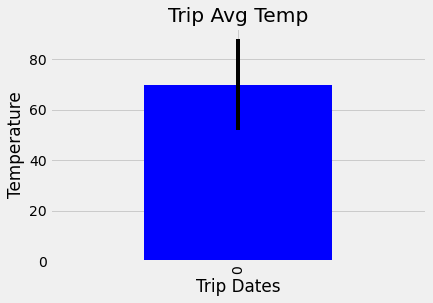

In [204]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

def yerr(start_date, end_date):
    return session.query(func.max(Meas.tobs)-func.min(Meas.tobs)).\
        filter(Meas.date >= start_date).filter(Meas.date <= end_date).all()

y_err = yerr('2016-02-28','2016-03-05')

y_value = calc_temps('2016-02-28','2016-03-05')

y_values_df = pd.DataFrame(y_value, columns = ['min_temp', 'avg_temp', 'max_temp'])
y_values_df
avg_temp_df = y_values_df['avg_temp']
avg_temp_df.plot.bar(yerr = y_err, ylabel = 'Temperature', xlabel = 'Trip Dates', title = 'Trip Avg Temp', color = 'blue', align = 'center')






In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_query = session.execute("SELECT SUM(m.prcp), s.station, s.name, s.latitude, s.longitude, s.elevation FROM station AS s LEFT JOIN measurement AS m ON m.station = s.station WHERE m.date >= '2016-02-28' AND m.date <= '2016-03-05' GROUP BY s.station ORDER BY m.prcp DESC").fetchall()
prcp_query


[(0.33, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (0.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.01, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.02, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.12000000000000001, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.0, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [64]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Meas.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [139]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
date = []

start_date = dt.date(2017,2,28)
end_date = dt.date(2017,3,5)
date_range = pd.date_range(start_date,end_date)

for dates in date_range:
    date.append(dates.strftime("%m-%d"))
print(date)


for dates in date:
    normals.append(daily_normals(dates))
normals    


['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']


[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [163]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_df = pd.DataFrame(date, columns = ['date'])
dates_df



    

normals_temp = [normal[0] for normal in normals]
normals_temp
normals_df = pd.DataFrame(normals_temp, columns = ['min_temp','avg_temp', 'max_temp'])
normals_df
daily_norms_df = pd.concat([dates_df, normals_df], axis = 1)
daily_norms_df

,date,min_temp,avg_temp,max_temp
0,02-28,65.0,70.655172,80.0
1,03-01,64.0,70.032787,76.0
2,03-02,61.0,70.366667,78.0
3,03-03,60.0,70.068966,78.0
4,03-04,57.0,69.272727,77.0
5,03-05,60.0,67.890909,76.0


/Applications/anaconda3/envs/PythonData/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date', ylabel='Temperature'>

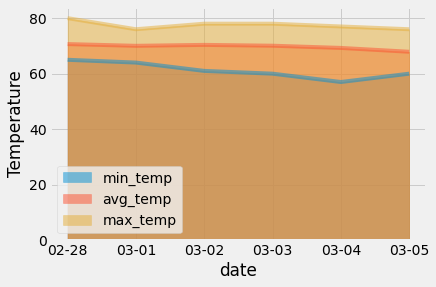

In [151]:
# Plot the daily normals as an area plot with `stacked=False`
#daily_norms_df.plot.area(stacked=False)
daily_norms_df.plot.area(x='date',stacked = False, ylabel = 'Temperature')
